# Prototype: delta

| Properties      | Data    |
|---------------|-----------|
| *Labels* | `['BENIGN', 'DDoS']` |
| *Normalization* | `Min-Max` |
| *Sample Size* | `10.000`|
| *Adversarial Attack* | `CW` |
| *Explanations* | `SHAP` |
| *Detector* | `Detect misclassified Samples` |


---

## *Has to be run first alone!*

In [3]:
# To import modules from the functions directory
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

## Data Preprocessing

In [4]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
label_names = ['BENIGN', 'DDoS'] # labels to include
sample_size = 10000 # sample size for each label -> 2 x sample_size = total samples

dataset = dp.build_dataset(label_names)

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df, used_indices = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=sample_size, random_sample_state=42)
print(f"Generate Features | Indices: {feature_df.index[:5]}... | Shape: {feature_df.shape}")
print(f"Generate Labels | Indices: {label_df.index[:5]}... | Shape: {label_df.shape}")
print(label_df.value_counts()) # -> will first show [0, 1] then [1, 0] if label number is equal

-- Building CICIDS2017 dataset --
--- Combining all CICIDS2017 files ---
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
--- Removing NaN and Infinity values ---
Removing 1358 Rows with NaN values
Removing 1509 Rows with Infinity values
--- Extracting labels ---
 Label
BENIGN    2271320
DDoS       128025
Name: count, dtype: int64
-- Generating normalizer --
--- Splitting labels and features ---
Zero Columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (20000, 79)
--- Splitti

## Split Data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18000, 70) (2000, 70) (18000, 2) (2000, 2)


## Create IDS

In [6]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

# TODO: build ids with complete dataset
# build ids and evaluate it on test data
ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)
# store prediction from X_train
y_pred = ids.predict(ids_model, X_train, columns=y_train.columns)
print(f"Predictions on Normal Data | Indices: {y_pred.index[:5]}... | Shape: {y_pred.shape}")

2025-03-19 13:30:32.581693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742387432.592838   75937 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742387432.596220   75937 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 13:30:32.608909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


2025-03-19 13:30:33.921821: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8706 - loss: 0.4759 - val_accuracy: 0.9778 - val_loss: 0.0711
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9816 - loss: 0.0563 - val_accuracy: 0.9808 - val_loss: 0.0477
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.0412 - val_accuracy: 0.9856 - val_loss: 0.0423
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9852 - loss: 0.0354 - val_accuracy: 0.9911 - val_loss: 0.0366
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9872 - loss: 0.0306 - val_accuracy: 0.9886 - val_loss: 0.0338
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0276 - val_accuracy: 0.9881 - val_loss: 0.0326
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9880 - loss: 0.0258 - val_accuracy: 0.9881 - val_loss: 0.0308
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9894 - loss: 0.0238 - val_accuracy: 0.9883 - val_

2025-03-19 13:30:36.442432: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
Predictions on Normal Data | Indices: Index([331819, 1964802, 2328813, 421676, 2361460], dtype='int64')... | Shape: (18000, 2)


## Generate Attacks

In [7]:
import functions.attack_generator as ag
import importlib
import numpy as np
importlib.reload(ag)

all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, X_train) # TODO: use all features for generating art model

# create smaller dataset
X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

import multiprocessing
num_cores = multiprocessing.cpu_count()

# generate attacks on the training data
X_adv = ag.generate_cw_attacks_parallel(art_model, X_train, target_label=1, num_cores=num_cores)
print(f"Create Adversarial Attack | Indices: {X_adv.index[:5]}... | Shape: {X_adv.shape}")

y_pred_adv = ag.evaluate_art_model(art_model, X_adv, y_train)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv.index[:5]}... | Shape: {y_pred_adv.shape}")

(16000, 70) (4000, 70) (16000, 2) (4000, 2)
Running attack using 24 CPU cores...

Process 77341 is generating adversarial examples for batch of size 666 
Process 77342 is generating adversarial examples for batch of size 666 
Process 77343 is generating adversarial examples for batch of size 666 
Process 77344 is generating adversarial examples for batch of size 666 


Process 77345 is generating adversarial examples for batch of size 666 


Process 77346 is generating adversarial examples for batch of size 666 

Process 77347 is generating adversarial examples for batch of size 666 

Process 77348 is generating adversarial examples for batch of size 666 
Process 77349 is generating adversarial examples for batch of size 666 


Process 77350 is generating adversarial examples for batch of size 666 

Process 77351 is generating adversarial examples for batch of size 666 

Process 77352 is generating adversarial examples for batch of size 666 

Process 77353 is generating adversarial exa

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/666 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/682 [00:00<?, ?it/s]

Create Adversarial Attack | Indices: Index([971894, 575390, 2464696, 2065223, 505249], dtype='int64')... | Shape: (16000, 70)
Accuracy: 75.59%
              precision    recall  f1-score   support

      BENIGN       1.00      0.51      0.68      8019
      ATTACK       0.67      1.00      0.80      7981

    accuracy                           0.76     16000
   macro avg       0.84      0.76      0.74     16000
weighted avg       0.84      0.76      0.74     16000

Confusion Matrix: Positive == BENIGN
TN: 4114, FP: 3905, FN: 0, TP: 7981
Predictions on Adversarial Attacks | Indices: Index([971894, 575390, 2464696, 2065223, 505249], dtype='int64')... | Shape: (16000, 2)


In [8]:
# find correctly classified samples
benign_indices = y_train[y_train['BENIGN'] == 1].index
print(f"Correct Benign Samples: {len(benign_indices)}")
benign_adv_predicted_indices = y_pred[y_pred['BENIGN'] == 1].index
print(f"    Predicted Benign Samples on Normal Data: {len(benign_adv_predicted_indices)}")
benign_predicted_adversarial_indices = y_pred_adv[y_pred_adv['BENIGN'] == 1].index
print(f"    Predicted Benign Samples on Adversarial Data: {len(benign_predicted_adversarial_indices)}")
attack_indices = y_train[y_train['ATTACK'] == 1].index
print(f"Correct Attack Samples: {len(attack_indices)}")
attack_adv_predicted_indices = y_pred[y_pred['ATTACK'] == 1].index
print(f"    Predicted Attack Samples on Normal Data: {len(attack_adv_predicted_indices)}")
attack_predicted_adversarial_indices = y_pred_adv[y_pred_adv['ATTACK'] == 1].index
print(f"    Predicted Attack Samples on Adversarial Data: {len(attack_predicted_adversarial_indices)}")
print("-----------------------------")
correctly_benign_classified_indices = benign_indices.intersection(benign_adv_predicted_indices)
print(f"Correctly classified as BENIGN from the IDS: {len(correctly_benign_classified_indices)} | Indices: {correctly_benign_classified_indices[:3]}")
misclassified_as_benign_due_attack_indices = attack_indices.intersection(attack_adv_predicted_indices).intersection(benign_predicted_adversarial_indices)
print(f"ATTACK sample misclassified as BENIGN due to adversarial attack: {len(misclassified_as_benign_due_attack_indices)} | Indices: {misclassified_as_benign_due_attack_indices[:3]}")

Correct Benign Samples: 7981
    Predicted Benign Samples on Normal Data: 9139
    Predicted Benign Samples on Adversarial Data: 11886
Correct Attack Samples: 8019
    Predicted Attack Samples on Normal Data: 8861
    Predicted Attack Samples on Adversarial Data: 4114
-----------------------------
Correctly classified as BENIGN from the IDS: 7967 | Indices: Index([971894, 575390, 2464696], dtype='int64')
ATTACK sample misclassified as BENIGN due to adversarial attack: 3748 | Indices: Index([450520, 386181, 418682], dtype='int64')


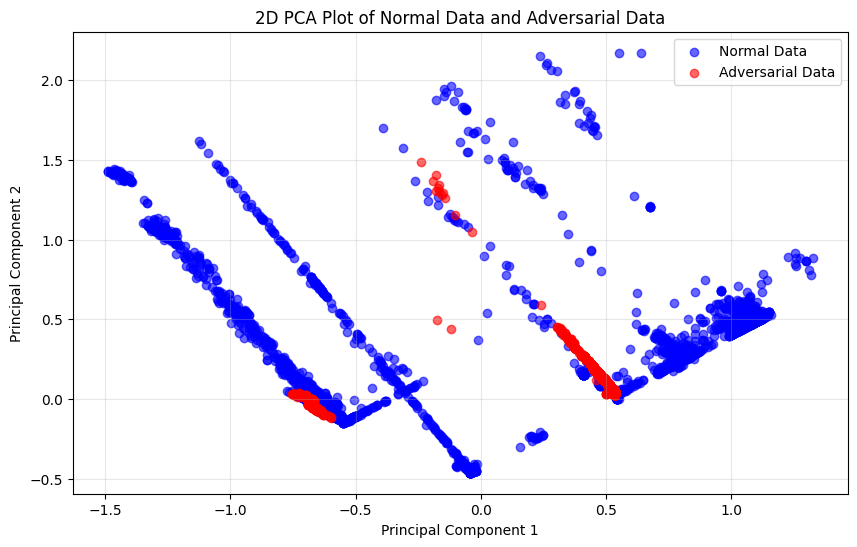

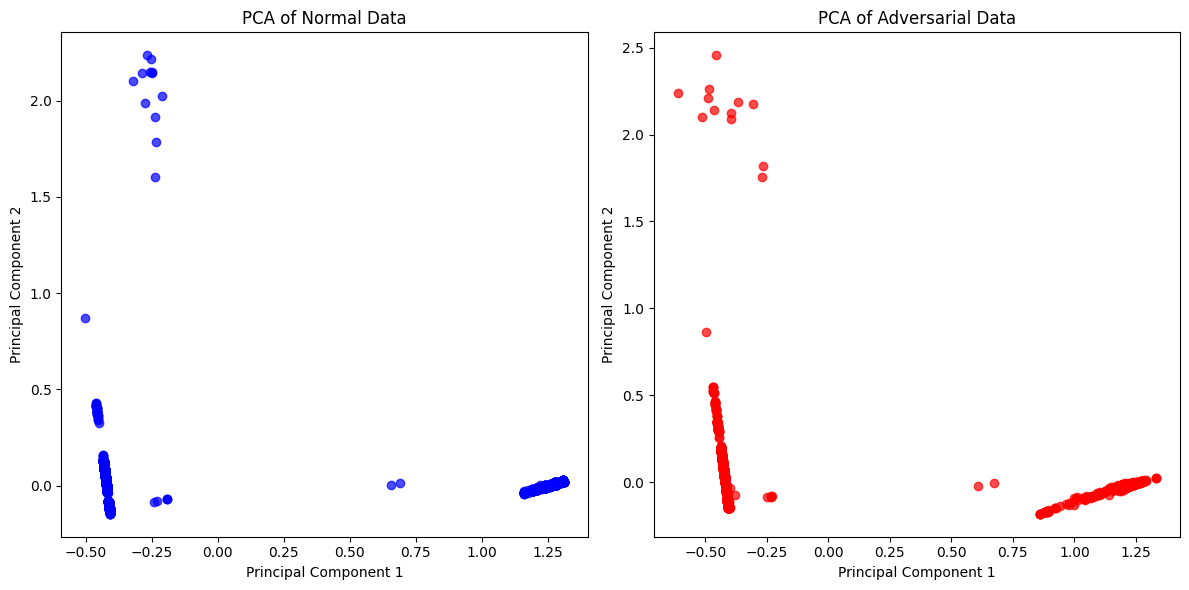

In [9]:
import functions.visualizer as visualizer
import importlib
importlib.reload(visualizer)

visualizer.visualize_data_distribution(X_train.loc[correctly_benign_classified_indices], 'Normal Data', X_adv.loc[misclassified_as_benign_due_attack_indices], 'Adversarial Data')
visualizer.pca_visualization_side_by_side(X_train.loc[misclassified_as_benign_due_attack_indices], 'Normal Data', X_adv.loc[misclassified_as_benign_due_attack_indices], 'Adversarial Data')

## Explainer

In [10]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values, shap_values_df = exp.generate_shap_values(explainer, X_train)
print(f"Generate Explanations | Indices: {shap_values_df.index[:5]}... | Shape: {shap_values_df.shape}")

shap_values_adv, shap_values_adv_df = exp.generate_shap_values(explainer, X_adv)
print(f"Generate Adversarial Explanations | Indices: {shap_values_adv_df.index[:5]}... | Shape: {shap_values_adv_df.shape}")

PermutationExplainer explainer: 16001it [09:52, 26.75it/s]                           


Generate Explanations | Indices: Index([971894, 575390, 2464696, 2065223, 505249], dtype='int64')... | Shape: (16000, 70)


PermutationExplainer explainer: 16001it [08:31, 30.73it/s]                           


Generate Adversarial Explanations | Indices: Index([971894, 575390, 2464696, 2065223, 505249], dtype='int64')... | Shape: (16000, 70)


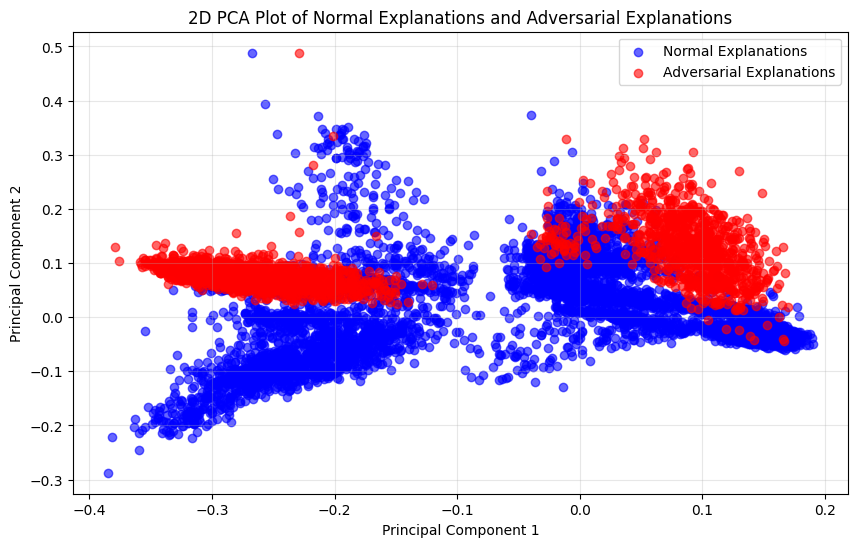

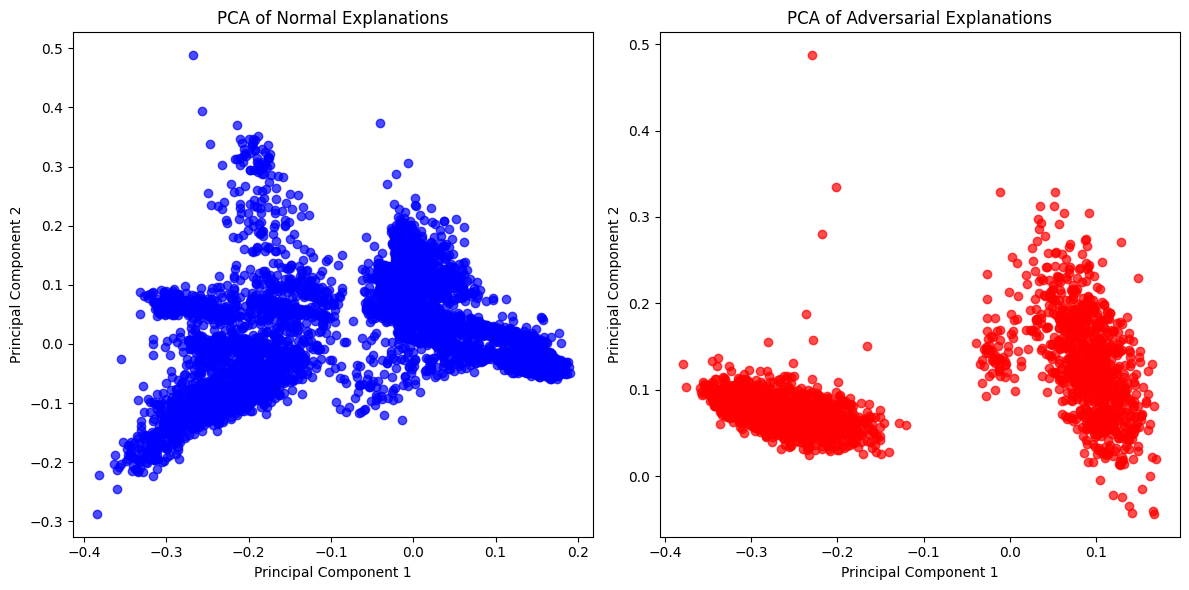

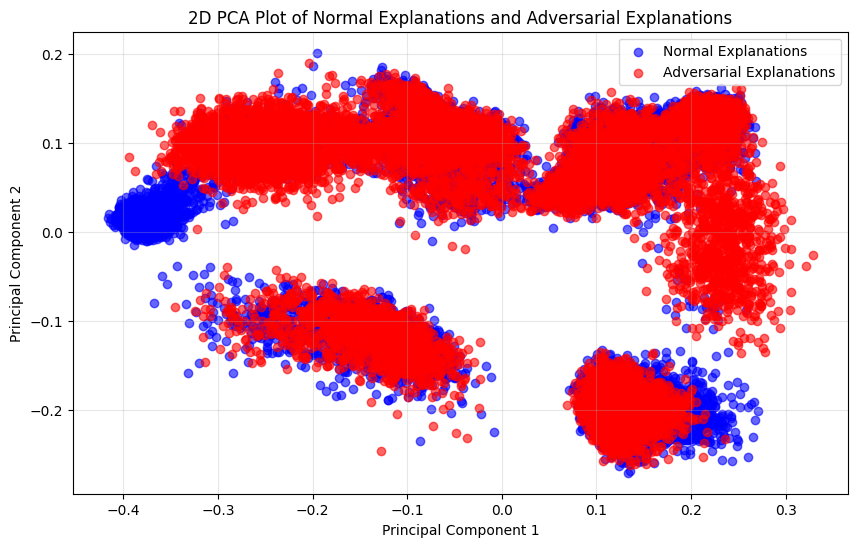

In [11]:
visualizer.visualize_data_distribution(shap_values_df.loc[correctly_benign_classified_indices], 'Normal Explanations', shap_values_adv_df.loc[misclassified_as_benign_due_attack_indices], 'Adversarial Explanations')
visualizer.pca_visualization_side_by_side(shap_values_df.loc[correctly_benign_classified_indices], 'Normal Explanations', shap_values_adv_df.loc[misclassified_as_benign_due_attack_indices], 'Adversarial Explanations')
visualizer.visualize_data_distribution(shap_values_df, 'Normal Explanations', shap_values_adv_df, 'Adversarial Explanations')

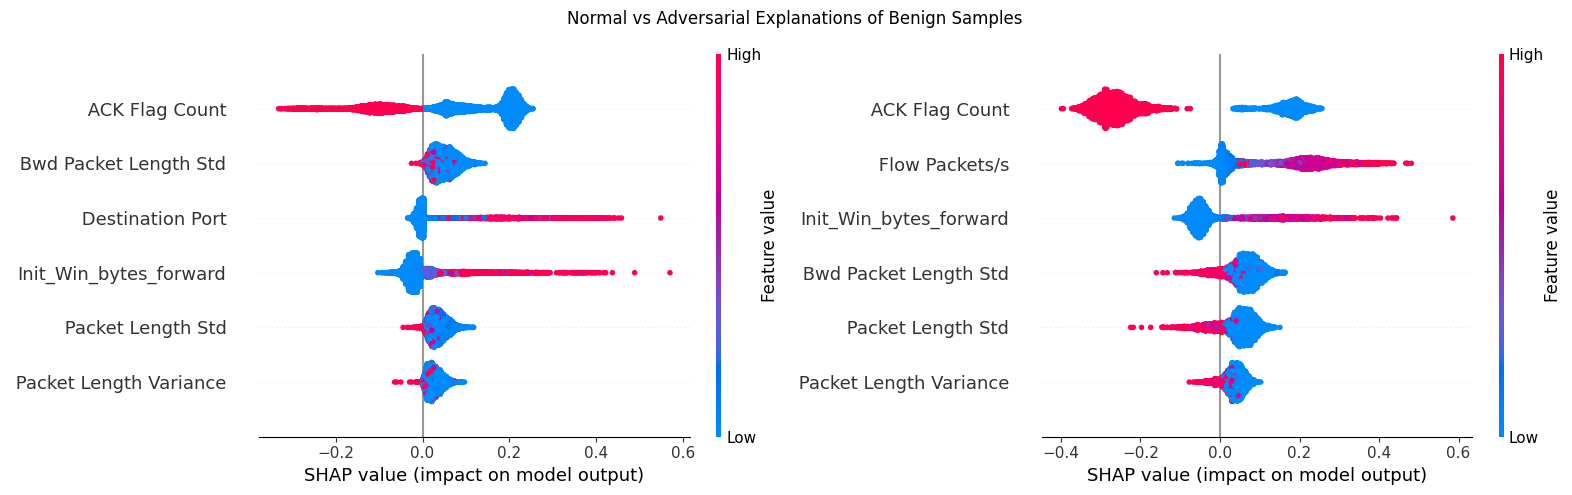

In [12]:
exp.plot_shap_summary_comparison(shap_values_df.loc[correctly_benign_classified_indices].values, X_train.loc[correctly_benign_classified_indices], shap_values_adv_df.loc[misclassified_as_benign_due_attack_indices].values, X_adv.loc[misclassified_as_benign_due_attack_indices], 6, title='Normal vs Adversarial Explanations of Benign Samples')

## Detector

In [13]:
import functions.detector as det
import importlib
importlib.reload(det)

# build detector to detect adversarial samples that misclassify attack samples as benign

# create dataframe
X, y = det.build_train_datasets(shap_values_df.loc[correctly_benign_classified_indices], shap_values_adv_df.loc[misclassified_as_benign_due_attack_indices])
print(X.shape, y.shape)

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)

(11715, 70) (11715, 2)
(10543, 70) (1172, 70) (10543, 2) (1172, 2)
Epoch 1/10


2025-03-19 14:28:35.013575: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7685 - loss: 0.6366 - val_accuracy: 0.9142 - val_loss: 0.2863
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9360 - loss: 0.2348 - val_accuracy: 0.9806 - val_loss: 0.0773
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9741 - loss: 0.0901 - val_accuracy: 0.9900 - val_loss: 0.0422
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9833 - loss: 0.0530 - val_accuracy: 0.9915 - val_loss: 0.0319
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9886 - loss: 0.0427 - val_accuracy: 0.9929 - val_loss: 0.0281
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9892 - loss: 0.0322 - val_accuracy: 0.9938 - val_loss: 0.0249
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0266 - val_accuracy: 0.9943 - val_loss: 0.0249
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9940 - loss: 0.0262 - val_accuracy: 0.9938 - val_loss: 0.0243
Epo

---
## Evaluation: Identify and Block Dangerous Adversarial Attacks

### Generate Dataset, Attacks and Explanations

In [14]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

# exclude previously used samples
dataset_eval_excluded = dataset.drop(index=used_indices)

X_eval, y_eval, used_eval_indices = dp.preprocess_data(dataset_eval_excluded, encoding_type, normalizer, zero_columns, sample_size=400, random_sample_state=17)
print(f"Generate Features | Indices: {X_eval.index[:5]}... | Shape: {X_eval.shape}")
print(f"Generate Labels | Indices: {y_eval.index[:5]}... | Shape: {y_eval.shape}")
print(y_eval.value_counts())

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (800, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
Generate Features | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')... | Shape: (800, 70)
Generate Labels | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')... | Shape: (800, 2)
BENIGN  ATTACK
False   True      400
True    False     400
Name: count, dtype: int64


In [15]:
importlib.reload(ag)

X_adv_eval = ag.generate_cw_attacks_parallel(art_model, X_eval, target_label=1, num_cores=num_cores)
print(f"Create Adversarial Attack | Indices: {X_adv_eval.index[:5]}... | Shape: {X_adv_eval.shape}")

y_pred_adv_eval = ag.evaluate_art_model(art_model, X_adv_eval, y_eval)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_eval.index[:5]}... | Shape: {y_pred_adv_eval.shape}")

Running attack using 24 CPU cores...

Process 153466 is generating adversarial examples for batch of size 33 
Process 153465 is generating adversarial examples for batch of size 33 
Process 153467 is generating adversarial examples for batch of size 33 
Process 153468 is generating adversarial examples for batch of size 33 
Process 153469 is generating adversarial examples for batch of size 33 
Process 153470 is generating adversarial examples for batch of size 33 
Process 153471 is generating adversarial examples for batch of size 33 
Process 153472 is generating adversarial examples for batch of size 33 
Process 153473 is generating adversarial examples for batch of size 33 
Process 153474 is generating adversarial examples for batch of size 33 
Process 153475 is generating adversarial examples for batch of size 33 
Process 153476 is generating adversarial examples for batch of size 33 
Process 153477 is generating adversarial examples for batch of size 33 
Process 153478 is generati

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

Create Adversarial Attack | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')... | Shape: (800, 70)
Accuracy: 76.25%
              precision    recall  f1-score   support

      BENIGN       1.00      0.53      0.69       400
      ATTACK       0.68      1.00      0.81       400

    accuracy                           0.76       800
   macro avg       0.84      0.76      0.75       800
weighted avg       0.84      0.76      0.75       800

Confusion Matrix: Positive == BENIGN
TN: 210, FP: 190, FN: 0, TP: 400
Predictions on Adversarial Attacks | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')... | Shape: (800, 2)


In [16]:
importlib.reload(exp)
X_eval_adv_shap_values, X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_eval)

print(f"Create Explanations | Indices: {X_eval_adv_shap_values_df.index[:5]}... | Shape: {X_eval_adv_shap_values_df.shape}")

PermutationExplainer explainer: 801it [00:25, 19.24it/s]                         

Create Explanations | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')... | Shape: (800, 70)


### Split Data into BENIGN and ATTACK Predicted Samples
Our detector wants to detect misclassified benign samples, so we need to divide attack and benign samples to further work on the benign samples.

In [17]:
importlib.reload(ids)

y_pred_eval = ids.predict(ids_model, X_eval, columns=y_eval.columns)
print(f"Prediction on Normal Data | Indices: {y_pred_eval.index[:5]}... | Shape: {y_pred_eval.shape}")

benign_predicted_indices = y_pred_eval[y_pred_eval['BENIGN'] == 1].index
print(f"#BENIGN: {len(benign_predicted_indices)} | Indices: {benign_predicted_indices[:5]}")
benign_adv_predicted_indices = y_pred_adv_eval[y_pred_adv_eval['BENIGN'] == 1].index
print(f"#BENIGN adv: {len(benign_adv_predicted_indices)} | Indices: {benign_adv_predicted_indices[:5]}")
attack_predicted_indices = y_pred_eval[y_pred_eval['ATTACK'] == 1].index
print(f"#ATTACK: {len(attack_predicted_indices)} | Indices: {attack_predicted_indices[:5]}")
attack_adv_predicted_indices = y_pred_adv_eval[y_pred_adv_eval['ATTACK'] == 1].index
print(f"#ATTACK adv: {len(attack_adv_predicted_indices)} | Indices: {attack_adv_predicted_indices[:5]}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
Prediction on Normal Data | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')... | Shape: (800, 2)
#BENIGN: 407 | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')
#BENIGN adv: 590 | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')
#ATTACK: 393 | Indices: Index([394000, 369668, 413116, 306511, 435503], dtype='int64')
#ATTACK adv: 210 | Indices: Index([394000, 413116, 476252, 388517, 343885], dtype='int64')


### From BENIGN Data: Find Correct and Misclassified Samples
We need these samples to test our detector if it correctly classified misclassified samples.

In [18]:
adv_correct_benign_indices = benign_predicted_indices.intersection(benign_adv_predicted_indices) # adversarial attack correctly classified as benign
print(f"#Correctly classified as BENIGN: {len(adv_correct_benign_indices)} | Indices: {adv_correct_benign_indices[:5]}")
adv_misclassified_benign_indices = attack_predicted_indices.intersection(benign_adv_predicted_indices) # attack misclassified as benign
print(f"#Misclassified as BENIGN: {len(adv_misclassified_benign_indices)} | Indices: {adv_misclassified_benign_indices[:5]}")

#Correctly classified as BENIGN: 407 | Indices: Index([2560682, 1415949, 844382, 2807160, 1563827], dtype='int64')
#Misclassified as BENIGN: 183 | Indices: Index([369668, 306511, 435503, 368058, 468411], dtype='int64')


### Create Dataset for Explanation-Detector of BENIGN Samples

In [19]:
# create dataframe that contains all benign classified samples
# TODO: change column names of y
X_eval_detector, y_eval_detector = det.build_train_datasets(X_eval_adv_shap_values_df.loc[adv_correct_benign_indices], X_eval_adv_shap_values_df.loc[adv_misclassified_benign_indices])
print(X_eval_detector.shape, X_eval_detector.shape)

(590, 70) (590, 70)


### Run Detector

In [20]:
from sklearn.utils import shuffle
import pandas as pd
importlib.reload(det)

X_eval_detector, y_eval_detector = shuffle(X_eval_detector, y_eval_detector, random_state=187)

y_pred_eval_detector = det.predict(detector, X_eval_detector, y_eval_detector.columns)

det.evaluate_model(y_pred_eval_detector, y_eval_detector)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Global Accuracy: 99.32%
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00       407
 ADVERSARIAL       0.98      0.99      0.99       183

    accuracy                           0.99       590
   macro avg       0.99      0.99      0.99       590
weighted avg       0.99      0.99      0.99       590

True Negative Rate: 99.26%
False Positive Rate: 0.74%
True Positive Rate: 99.45%
False Negative Rate: 0.55%


2025-03-19 14:31:14.763920: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


### Remove Bad Adversarial Attacks from BENIGN samples

In [21]:
X_eval_benign = X_eval.loc[benign_adv_predicted_indices]
X_eval_attack = X_eval.loc[attack_adv_predicted_indices]
y_eval_benign = y_eval.loc[benign_adv_predicted_indices]
y_eval_attack = y_eval.loc[attack_adv_predicted_indices]
print(f"#BENIGN predicted samples: {X_eval_benign.shape[0]} | #ATTACK predicted samples: {X_eval_attack.shape[0]}")

# find misclassified samples
predicted_bad_indices = y_pred_eval_detector[y_pred_eval_detector['ADVERSARIAL'] == 1].index
print(f"#Found Misclassified samples in BENIGN predicted samples: {len(predicted_bad_indices)}")

# recreate dataset without bad adversarial attacks:
X_benign = X_eval_benign.drop(predicted_bad_indices)
y_benign = y_eval_benign.drop(predicted_bad_indices)
print(f"#BENIGN samples after removing bad adversarial attacks: {X_benign.shape[0]}")

# recreate original dataset with all attack predicted samples and all benign predicted samples without the bad adversarial attacks
print(f"New Dataset: #BENIGN: {X_benign.shape[0]} | #ATTACK: {X_eval_attack.shape[0]}")
X_test = pd.concat([X_benign, X_eval_attack])
y_test = pd.concat([y_benign, y_eval_attack])
print(f"#Samples before: {X_eval.shape[0]}; #Samples after: {X_test.shape[0]}")

#BENIGN predicted samples: 590 | #ATTACK predicted samples: 210
#Found Misclassified samples in BENIGN predicted samples: 185
#BENIGN samples after removing bad adversarial attacks: 405
New Dataset: #BENIGN: 405 | #ATTACK: 210
#Samples before: 800; #Samples after: 615


### IDS on all Samples (Without the removed meanigful adversarial attacks)

In [22]:
y_pred = ids_model.predict(X_test)
# Evaluate
det.evaluate_model(y_pred, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Global Accuracy: 99.19%
              precision    recall  f1-score   support

      BENIGN       0.99      1.00      0.99       399
      ATTACK       1.00      0.98      0.99       216

    accuracy                           0.99       615
   macro avg       0.99      0.99      0.99       615
weighted avg       0.99      0.99      0.99       615

True Negative Rate: 100.00%
False Positive Rate: 0.00%
True Positive Rate: 97.69%
False Negative Rate: 2.31%


---
## Manual Evaluation
We perform the whole two-stages approach on new unseen data and evaluate the following scores:
- Recall
- Precision
- Accuracy
- F1 Score

In [23]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

# exclude previously used samples
dataset_eval_excluded = dataset_eval_excluded.drop(index=used_eval_indices)

X_eval, y_eval, used_eval_indices = dp.preprocess_data(dataset_eval_excluded, encoding_type, normalizer, zero_columns, sample_size=400, random_sample_state=17)
print(f"Generate Features | Indices: {X_eval.index[:5]}... | Shape: {X_eval.shape}")
print(f"Generate Labels | Indices: {y_eval.index[:5]}... | Shape: {y_eval.shape}")
print(y_eval.value_counts())

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (800, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
Generate Features | Indices: Index([650449, 2297775, 549451, 987006, 2479090], dtype='int64')... | Shape: (800, 70)
Generate Labels | Indices: Index([650449, 2297775, 549451, 987006, 2479090], dtype='int64')... | Shape: (800, 2)
BENIGN  ATTACK
False   True      400
True    False     400
Name: count, dtype: int64


In [24]:
importlib.reload(ag)

X_adv_eval = ag.generate_cw_attacks_parallel(art_model, X_eval, target_label=1, num_cores=num_cores)
print(f"Create Adversarial Attack | Indices: {X_adv_eval.index[:5]}... | Shape: {X_adv_eval.shape}")

y_pred_adv_eval = ag.evaluate_art_model(art_model, X_adv_eval, y_eval)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_eval.index[:5]}... | Shape: {y_pred_adv_eval.shape}")

Running attack using 24 CPU cores...

Process 159329 is generating adversarial examples for batch of size 33 
Process 159330 is generating adversarial examples for batch of size 33 
Process 159331 is generating adversarial examples for batch of size 33 
Process 159332 is generating adversarial examples for batch of size 33 
Process 159333 is generating adversarial examples for batch of size 33 
Process 159335 is generating adversarial examples for batch of size 33 
Process 159334 is generating adversarial examples for batch of size 33 
Process 159336 is generating adversarial examples for batch of size 33 
Process 159337 is generating adversarial examples for batch of size 33 
Process 159339 is generating adversarial examples for batch of size 33 
Process 159340 is generating adversarial examples for batch of size 33 
Process 159342 is generating adversarial examples for batch of size 33 
Process 159343 is generating adversarial examples for batch of size 33 
Process 159338 is generati

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/33 [00:00<?, ?it/s]

Create Adversarial Attack | Indices: Index([650449, 2297775, 549451, 987006, 2479090], dtype='int64')... | Shape: (800, 70)
Accuracy: 75.12%
              precision    recall  f1-score   support

      BENIGN       1.00      0.50      0.67       400
      ATTACK       0.67      1.00      0.80       400

    accuracy                           0.75       800
   macro avg       0.83      0.75      0.73       800
weighted avg       0.83      0.75      0.73       800

Confusion Matrix: Positive == BENIGN
TN: 201, FP: 199, FN: 0, TP: 400
Predictions on Adversarial Attacks | Indices: Index([650449, 2297775, 549451, 987006, 2479090], dtype='int64')... | Shape: (800, 2)


In [25]:
importlib.reload(exp)
X_eval_adv_shap_values, X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_eval)

print(f"Create Explanations | Indices: {X_eval_adv_shap_values_df.index[:5]}... | Shape: {X_eval_adv_shap_values_df.shape}")

PermutationExplainer explainer: 801it [00:26, 19.00it/s]                         

Create Explanations | Indices: Index([650449, 2297775, 549451, 987006, 2479090], dtype='int64')... | Shape: (800, 70)


In [26]:
benign_eval_idx = y_eval[y_eval['BENIGN'] == 1].index
attack_eval_idx = y_eval[y_eval['ATTACK'] == 1].index

pred_benign_idx = y_pred_adv_eval[y_pred_adv_eval['BENIGN'] == 1].index
pred_attack_idx = y_pred_adv_eval[y_pred_adv_eval['ATTACK'] == 1].index

# predict
X_eval_detector = X_eval_adv_shap_values_df.loc[pred_benign_idx]

y_pred_eval_detector = det.predict(detector, X_eval_detector, y_eval.columns)
correctly_classified_det_idx = y_pred_eval_detector[y_pred_eval_detector['BENIGN'] == 1].index
misclassified_det_idx = y_pred_eval_detector[y_pred_eval_detector['ATTACK'] == 1].index


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


2025-03-19 14:33:51.607417: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [27]:
# After IDS Stage
TN = len(attack_eval_idx.intersection(pred_attack_idx)) # IDS classifies 'ATTACK' samples as 'ATTACK'
print(f"IDS classifies 'ATTACK' samples as 'ATTACK': {TN}")
FN = len(benign_eval_idx.intersection(pred_attack_idx)) # IDS classifies 'BENIGN' samples as 'ATTACK'
print(f"IDS mis-classifies 'BENIGN' samples as 'ATTACK': {FN}")

# After Detector Stage
TP = len(benign_eval_idx.intersection(correctly_classified_det_idx)) # Detector classifies 'BENIGN' samples as correct 'BENIGN'
print(f"Detector classifies 'BENIGN' samples as correct 'BENIGN': {TP}")
FP = len(attack_eval_idx.intersection(correctly_classified_det_idx)) # Detector classifies 'ATTACK' samples as correct 'BENIGN'
print(f"Detector mis-classifies 'ATTACK' samples as correct 'BENIGN': {FP}")

TN_2 = len(attack_eval_idx.intersection(misclassified_det_idx)) # Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK'
print(f"Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK': {TN_2}")
FN_2 = len(benign_eval_idx.intersection(misclassified_det_idx)) # Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK'
print(f"Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK': {FN_2}")

# Sum up TN & FN from both stages
TN = TN + TN_2
FN = FN + FN_2

print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"TN: {TN}")
print(f"FN: {FN}")
print(f"Sum: {TP + FP + TN + FN}")

IDS classifies 'ATTACK' samples as 'ATTACK': 201
IDS mis-classifies 'BENIGN' samples as 'ATTACK': 0
Detector classifies 'BENIGN' samples as correct 'BENIGN': 398
Detector mis-classifies 'ATTACK' samples as correct 'BENIGN': 5
Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK': 194
Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK': 2
TP: 398
FP: 5
TN: 395
FN: 2
Sum: 800


In [28]:
from sklearn.metrics import classification_report

print(f"Global Accuracy: {(TP + TN) / (TP + FP + TN + FN) * 100:.2f}%")

# Construct a fake y_true and y_pred to match sklearn's classification_report format
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['BENIGN', 'ATTACK'])
print(report)

print(f"True Negative Rate: {TN/(TN+FP)*100:.2f}%")
print(f"False Positive Rate: {FP/(TN+FP)*100:.2f}%")
print(f"True Positive Rate: {TP/(TP+FN)*100:.2f}%")
print(f"False Negative Rate: {FN/(TP+FN)*100:.2f}%")

Global Accuracy: 99.12%
              precision    recall  f1-score   support

      BENIGN       0.99      0.99      0.99       400
      ATTACK       0.99      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

True Negative Rate: 98.75%
False Positive Rate: 1.25%
True Positive Rate: 99.50%
False Negative Rate: 0.50%
